
# Space Measurements of the Sun: From Observations to Simple Simulations (4-hour module)

**Audience:** Undergraduate students  
**Format:** Concepts + guided hands-on  
**Prerequisites:** Basic calculus/physics; minimal Python experience is OK  
**Tools:** Python, NumPy, Matplotlib

---

## Learning goals (what you should be able to do by the end)
1. Explain what common space instruments *measure* vs what is *inferred*.
2. Understand remote sensing vs in-situ measurements in the context of the Sun.
3. Build a simple **synthetic solar magnetic field** on a latitude grid.
4. Evolve it with a simplified physical process (**diffusion**).
5. Create a synthetic **spacecraft-like measurement** (line-of-sight projection + noise + missing polar coverage).
6. Compare *truth* vs *measurement* and interpret limitations.

> This notebook is designed to be run top-to-bottom in a single session.



## 0) Setup

We will use:
- **NumPy** for arrays and simple numerics
- **Matplotlib** for plots

If you get an import error, install packages (typical command):  
`pip install numpy matplotlib`


In [1]:

import numpy as np
import matplotlib.pyplot as plt

# For reproducibility of noisy "measurements"
rng = np.random.default_rng(42)

def nice_plot():
    """Small helper for clean plots."""
    plt.grid(True, alpha=0.25)
    plt.tight_layout()



## 1) Concepts in 10 minutes (quick reference)

### Remote sensing vs in-situ
- **Remote sensing:** you measure *photons* (images, spectra) and infer physical quantities (temperature, velocity, magnetic field proxies).
- **In-situ:** you directly sample *local* plasma/magnetic fields where the spacecraft is (e.g., magnetometer, plasma analyzer).

### What does a magnetogram measure?
A solar magnetogram typically measures **line-of-sight (LOS) magnetic field**:
- What you *want* physically: the **radial** field at the surface, Br(theta,phi)
- What you often measure: B_LOS, which depends on viewing geometry.



## 2) Build a “truth” model: synthetic solar radial field Br(theta)

To keep things simple, we use a **1D latitude model** (no longitude):
- theta = colatitude (0 at North pole, pi/2 at equator, pi at South pole)
- latitude = 90° − theta°

We'll construct a simple pattern that resembles large-scale fields:
- A **dipole-like** component (strongest near poles)
- Optional **active-region belt** features at mid-latitudes


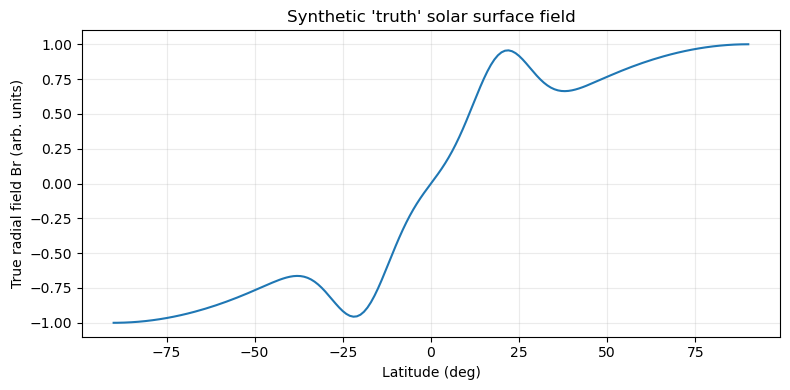

In [2]:

# Latitude grid
N_theta = 181                      # points in colatitude
theta = np.linspace(0, np.pi, N_theta)
lat_deg = 90.0 - np.degrees(theta) # latitude in degrees (+N to -S)

def build_truth_field(theta, dipole_amp=1.0, belt_amp=0.6, belt_lat=20, belt_width=8):
    """
    Create a synthetic 'true' radial field Br(theta):
      - dipole-like term ~ cos(theta)
      - mid-latitude belts (two Gaussians, N and S), opposite sign
    """
    Br = dipole_amp * np.cos(theta)

    # Mid-latitude belts in latitude (degrees): +belt_lat and -belt_lat
    lat = 90.0 - np.degrees(theta)

    def gauss(x, mu, sig):
        return np.exp(-(x - mu)**2 / (2*sig**2))

    belt_N = gauss(lat, +belt_lat, belt_width)
    belt_S = gauss(lat, -belt_lat, belt_width)

    # Opposite polarity belts as a simple proxy of emergence
    Br += belt_amp * (belt_N - belt_S)
    return Br

Br0 = build_truth_field(theta)

plt.figure(figsize=(8,4))
plt.plot(lat_deg, Br0)
plt.xlabel("Latitude (deg)")
plt.ylabel("True radial field Br (arb. units)")
plt.title("Synthetic 'truth' solar surface field")
nice_plot()
plt.show()



## 3) A simple physical evolution: diffusion on a sphere (1D latitude)

A simplified model of field spreading by turbulent motions is **diffusion**.

Schematic idea:
dB/dt ≈ eta * Laplacian(B)

We implement a simple explicit scheme. This is NOT a research-grade solver—it's a teaching model.


dt=0.02 too large; reducing to dt_max=0.00203 for stability.


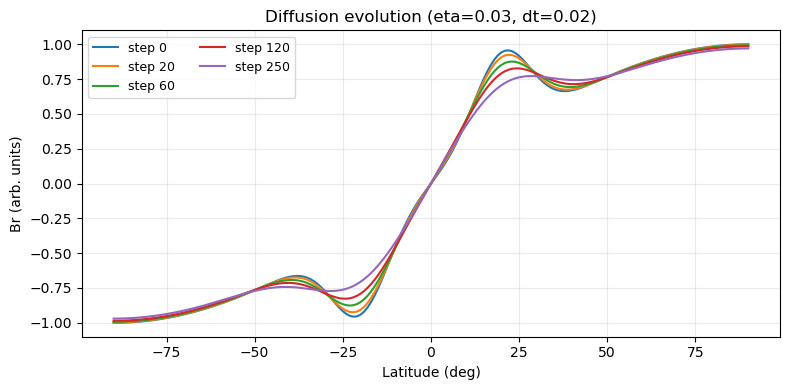

In [7]:

def laplacian_1d_theta(B, theta):
    """
    Stable spherical theta-Laplacian:
      Lap(B) = (1/sinθ) d/dθ ( sinθ dB/dθ )
    with Neumann-like treatment at poles (dB/dθ = 0 at θ=0,π).
    """
    dtheta = theta[1] - theta[0]
    sinT = np.sin(theta)

    # Enforce zero-gradient at poles by mirroring boundary values
    Bm = B.copy()
    Bm[0]  = Bm[1]
    Bm[-1] = Bm[-2]

    # dB/dθ
    dB = np.zeros_like(Bm)
    dB[1:-1] = (Bm[2:] - Bm[:-2]) / (2*dtheta)
    dB[0] = 0.0
    dB[-1] = 0.0

    # Flux F = sinθ dB/dθ
    F = sinT * dB

    # dF/dθ
    dF = np.zeros_like(Bm)
    dF[1:-1] = (F[2:] - F[:-2]) / (2*dtheta)
    dF[0] = (F[1] - F[0]) / dtheta
    dF[-1] = (F[-1] - F[-2]) / dtheta

    # Divide safely away from poles; set poles using neighbor values
    Lap = np.zeros_like(Bm)
    interior = (sinT > 1e-3)
    Lap[interior] = dF[interior] / sinT[interior]
    Lap[0]  = Lap[1]
    Lap[-1] = Lap[-2]
    return Lap


def diffuse(B0, theta, eta=0.02, dt=0.2, nsteps=200):
    """Explicit diffusion with a conservative stability guard."""
    dtheta = theta[1] - theta[0]
    dt_max = 0.2 * dtheta**2 / eta
    if dt > dt_max:
        print(f"dt={dt:.3g} too large; reducing to dt_max={dt_max:.3g} for stability.")
        dt = dt_max

    B = B0.copy()
    history = [B.copy()]
    for _ in range(nsteps):
        B = B + dt * eta * laplacian_1d_theta(B, theta)
        # stop early if it blows up (extra safety)
        if not np.all(np.isfinite(B)):
            raise RuntimeError("Solution became non-finite (NaN/Inf). Reduce dt or eta.")
        history.append(B.copy())
    return np.array(history)


# Try a diffusion run (students can edit eta)
eta = 0.03
dt = 0.02
nsteps = 250
hist = diffuse(Br0, theta, eta=eta, dt=dt, nsteps=nsteps)

# Plot snapshots
plt.figure(figsize=(8,4))
for idx in [0, 20, 60, 120, 250]:
    plt.plot(lat_deg, hist[idx], label=f"step {idx}")
plt.xlabel("Latitude (deg)")
plt.ylabel("Br (arb. units)")
plt.title(f"Diffusion evolution (eta={eta}, dt={dt})")
plt.legend(ncol=2, fontsize=9)
nice_plot()
plt.show()



### Quick exploration (student activity)
Change **eta** and see how the field smooths out faster or slower.

- Larger eta → quicker smoothing (features disappear faster)
- Smaller eta → slower smoothing (features persist longer)

Try: `eta = 0.01`, `eta = 0.05`



## 4) Simulate a spacecraft-like measurement: LOS + noise + missing poles

A telescope/spacecraft often measures **line-of-sight** field rather than radial.

Teaching approximation for an equatorial observer:
B_LOS ≈ Br * cos(latitude)

We also add:
- Instrument noise
- Polar data gap (missing data near poles)


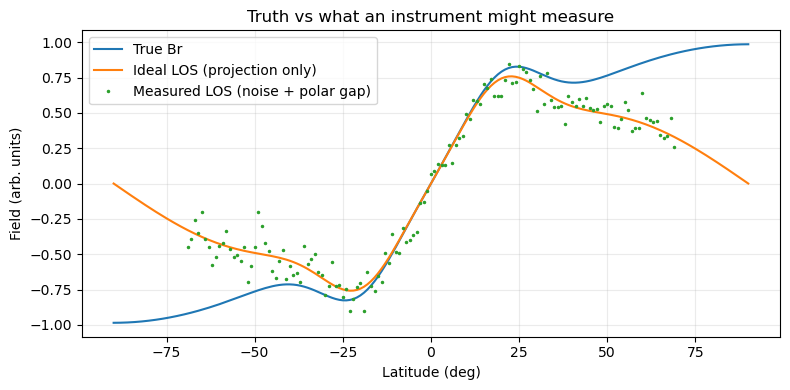

In [8]:

def observe_los_from_equator(Br, lat_deg, noise_sigma=0.08, polar_cut_deg=75):
    """
    Create a synthetic LOS measurement from an equatorial observer.
    Projection factor ~ cos(latitude) (simple teaching approximation).

    polar_cut_deg: beyond this |lat|, mark data as missing (NaN).
    """
    proj = np.cos(np.radians(lat_deg))  # 1 at equator, 0 at poles

    Blos = Br * proj

    # Add Gaussian noise
    Blos_noisy = Blos + rng.normal(0.0, noise_sigma, size=Br.shape)

    # Mask polar regions (simulate limited sensitivity/coverage)
    mask = np.abs(lat_deg) >= polar_cut_deg
    Blos_noisy = Blos_noisy.copy()
    Blos_noisy[mask] = np.nan

    return Blos, Blos_noisy, proj

# Take one snapshot as "truth" and build the observation
Br_true = hist[120]
Blos_ideal, Blos_meas, proj = observe_los_from_equator(
    Br_true, lat_deg, noise_sigma=0.10, polar_cut_deg=70
)

plt.figure(figsize=(8,4))
plt.plot(lat_deg, Br_true, label="True Br")
plt.plot(lat_deg, Blos_ideal, label="Ideal LOS (projection only)")
plt.plot(lat_deg, Blos_meas, ".", ms=3, label="Measured LOS (noise + polar gap)")
plt.xlabel("Latitude (deg)")
plt.ylabel("Field (arb. units)")
plt.title("Truth vs what an instrument might measure")
plt.legend()
nice_plot()
plt.show()



## 5) Can we “recover” radial field from LOS? (simple inversion idea)

If we know the projection factor cos(latitude), a naive inversion is:

Br ≈ B_LOS / cos(latitude)

But this becomes unstable near poles because cos(latitude) → 0. That’s why polar fields are difficult.

We demonstrate that:
- inversion is OK at mid-latitudes
- it becomes unreliable near poles


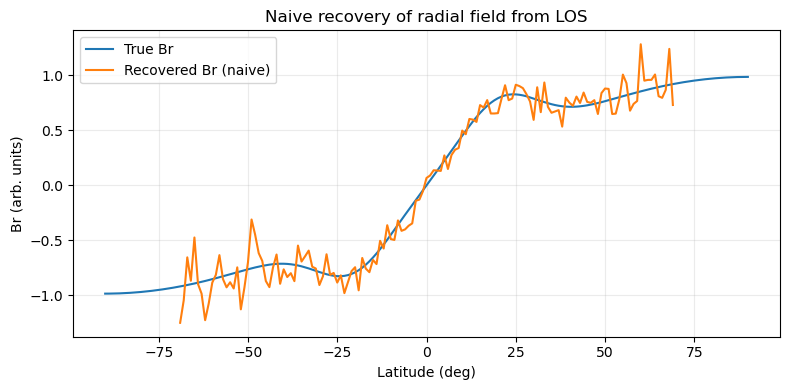

RMSE (where defined): 0.13189671983157183


In [9]:

def naive_invert_los(Blos_meas, proj, proj_floor=0.25):
    """Naive inversion Br ~ Blos / proj, with a floor to avoid blow-up."""
    proj_safe = np.maximum(proj, proj_floor)
    return Blos_meas / proj_safe

Br_rec = naive_invert_los(Blos_meas, proj, proj_floor=0.25)

plt.figure(figsize=(8,4))
plt.plot(lat_deg, Br_true, label="True Br")
plt.plot(lat_deg, Br_rec, label="Recovered Br (naive)")
plt.xlabel("Latitude (deg)")
plt.ylabel("Br (arb. units)")
plt.title("Naive recovery of radial field from LOS")
plt.legend()
nice_plot()
plt.show()

# Quantify error (ignoring NaNs)
valid = np.isfinite(Br_rec) & np.isfinite(Br_true)
rmse = np.sqrt(np.mean((Br_rec[valid] - Br_true[valid])**2))
print("RMSE (where defined):", rmse)



## 6) Mini-project (30–45 minutes): choose one

### Option A: Instrument noise study
- Increase `noise_sigma` and see how RMSE changes.
- Identify which latitudes are most affected.

### Option B: Polar data gap study
- Change `polar_cut_deg` (e.g., 60, 75, 80).
- Explain why missing polar coverage matters for global field interpretation.

### Option C: Diffusivity study
- Run two diffusion models with different `eta`.
- Compare how quickly mid-latitude belts disappear.

**Deliverable (5 minutes):**
- One plot + 2–3 sentences interpreting what happened.



## 7) Wrap-up (talking points for the instructor)

- Measurements are **geometry-dependent** and **instrument-limited**.
- Even a simple model helps us understand what is *reliable* in data and what is not.
- Simulations are not “truth,” but they are powerful for:
  - testing hypotheses,
  - estimating uncertainty,
  - connecting measurements to physical processes.

Possible future extensions:
- Add meridional flow (advection)
- Add bipolar region emergence as a time-dependent source term
- Move from 1D latitude → 2D (latitude + longitude)
